<a href="https://colab.research.google.com/github/garvinfrank/Handwritten-text-recognition-HTR/blob/main/handwriting_recognition_ss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
vaibhao_handwritten_characters_path = kagglehub.dataset_download('vaibhao/handwritten-characters')
landlord_handwriting_recognition_path = kagglehub.dataset_download('landlord/handwriting-recognition')

print('Data source import complete.')


100%|██████████| 1.62G/1.62G [00:42<00:00, 41.3MB/s]

Extracting files...


100%|██████████| 1.26G/1.26G [00:32<00:00, 41.5MB/s]

Extracting files...


Data source import complete.


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import random
import cv2
import imutils
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation, Flatten, Dense,MaxPooling2D, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("✅ GPU memory growth enabled.")
else:
    print("❌ No GPU detected.")


✅ GPU memory growth enabled.


In [ ]:
dir = os.path.join(vaibhao_handwritten_characters_path, "Train") # Use os.path.join to create the path
train_data = []
img_size = 32
non_chars = ["#","$","&","@"]
for i in os.listdir(dir):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(dir,i)
    for j in os.listdir(sub_directory):
        count+=1
        print(count)
        if count > 500:
            break
        img = cv2.imread(os.path.join(sub_directory,j),0)
        img = cv2.resize(img,(img_size,img_size))
        train_data.append([img,i])

Streaming output truncated to the last 5000 lines.
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
27

In [ ]:
len(train_data)

17500

In [ ]:
# val_dir = "../input/handwritten-characters/Validation/"
val_dir = os.path.join(vaibhao_handwritten_characters_path, "Validation") # Changed VAL_dir to val_dir
val_data = []
img_size = 32
for i in os.listdir(val_dir):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(val_dir,i) # Changed VAL_dir to val_dir
    for j in os.listdir(sub_directory):
        count+=1
        print(count)
        if count > 100:
            break
        img = cv2.imread(os.path.join(sub_directory,j),0)
        img = cv2.resize(img,(img_size,img_size))
        val_data.append([img,i])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
4

In [ ]:
len(val_data)

3500

In [ ]:
random.shuffle(train_data)
random.shuffle(val_data)

In [ ]:
train_X = []
train_Y = []
for features,label in train_data:
    train_X.append(features)
    train_Y.append(label)

In [ ]:
val_X = []
val_Y = []
for features,label in val_data:
    val_X.append(features)
    val_Y.append(label)

In [ ]:
LB = LabelBinarizer()
train_Y = LB.fit_transform(train_Y)
val_Y = LB.fit_transform(val_Y)

In [ ]:
train_X = np.array(train_X)/255.0
train_X = train_X.reshape(-1,32,32,1)
train_Y = np.array(train_Y)

In [ ]:
val_X = np.array(val_X)/255.0
val_X = val_X.reshape(-1,32,32,1)
val_Y = np.array(val_Y)

In [ ]:
print(train_X.shape, val_X.shape)

(17500, 32, 32, 1) (3500, 32, 32, 1)


In [ ]:
print(train_Y.shape, val_Y.shape)

(17500, 35) (3500, 35)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input

model = Sequential([
    Input(shape=(32, 32, 1)),

    Conv2D(32, (3, 3), padding="same", activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(35, activation='softmax')  # Update this if you have more/less classes
])


In [ ]:
#Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 5, 5, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 35)                  │           4,515 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 162,851 (636.14 KB)

 Trainable params: 162,851 (636.14 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    train_X,
    train_Y,
    epochs=100,
    batch_size=32,
    validation_data=(val_X, val_Y),
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.3761 - loss: 2.2330 - val_accuracy: 0.7906 - val_loss: 0.6634
Epoch 2/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7634 - loss: 0.7269 - val_accuracy: 0.8431 - val_loss: 0.4929
Epoch 3/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8212 - loss: 0.5379 - val_accuracy: 0.8589 - val_loss: 0.4416
Epoch 4/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8475 - loss: 0.4498 - val_accuracy: 0.8686 - val_loss: 0.4109
Epoch 5/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8652 - loss: 0.3848 - val_accuracy: 0.8806 - val_loss: 0.3959
Epoch 6/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8722 - loss: 0.3547 - val_accuracy: 0.8737 - val_loss: 0.3793
Epoch 7/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8866 - loss: 0.3246 - val_accuracy: 0.8677 - val_loss: 0.4038
Epoch 8/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8930 - loss: 0.2976 - val_ac

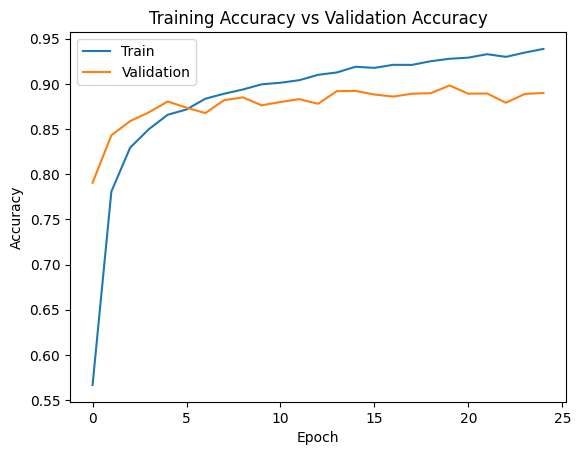

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

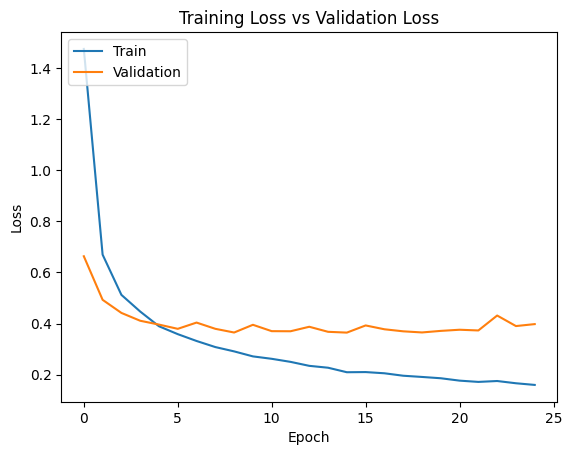

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

In [ ]:
def get_word(letter):
    word = "".join(letter)
    return word

In [ ]:
letter,image = get_letters("../input/handwriting-recognition/validation_v2/validation/VALIDATION_0005.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

In [ ]:
letter,image = get_letters("../input/handwriting-recognition/test_v2/test/TEST_0007.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

In [ ]:
val_loss, val_accuracy = model.evaluate(val_X, val_Y, verbose=1)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8857 - loss: 0.3804
Validation Accuracy: 89.23%


In [ ]:
import os

def get_letters(img_path):
    """
    Extracts letters from an image.

    Args:
        img_path (str): The path to the image file.

    Returns:
        tuple: A tuple containing the extracted letters and the processed image.
    """
    letters = []
    # Check if file exists
    if not os.path.exists(img_path):
        print(f"Error: Image file not found at path: {img_path}")
        return letters, None  # Return empty list and None for image

    image = cv2.imread(img_path)
    # Check if image was loaded successfully
    if image is None:
        print(f"Error: Could not load image from path: {img_path}")
        return letters, None  # Return empty list and None for image

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh1 = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(thresh1, None, iterations=2)

    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]

    for c in cnts:
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            roi = gray[y:y + h, x:x + w]
            thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            thresh = cv2.resize(thresh, (32, 32), interpolation=cv2.INTER_CUBIC)
            thresh = thresh.astype("float32") / 255.0
            thresh = np.expand_dims(thresh, axis=-1)
            thresh = thresh.reshape(1, 32, 32, 1)
            ypred = model.predict(thresh)
            ypred = LB.inverse_transform(ypred)
            [x] = ypred
            letters.append(x)

    return letters, image #Ensuring the image is returned

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
BENE5


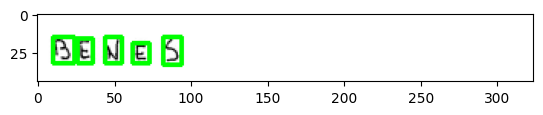

In [ ]:
img_path = os.path.join(landlord_handwriting_recognition_path, "train_v2/train/TRAIN_00003.jpg")  # Join the path to the image
letter, image = get_letters(img_path)  # Pass the joined path to the get_letters function
# Check if image was loaded successfully before proceeding
if image is not None:
    word = get_word(letter)
    print(word)
    plt.imshow(image)
else:
    print("Image could not be loaded or processed.")


# plt.imshow(img_path)

Error: Image file not found at path: /root/.cache/kagglehub/datasets/landlord/handwriting-recognition/versions/1/test_v2/test/TEST_0000.jpg
Could not process image: /root/.cache/kagglehub/datasets/landlord/handwriting-recognition/versions/1/test_v2/test/TEST_0000.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Image 1: WIV1IW


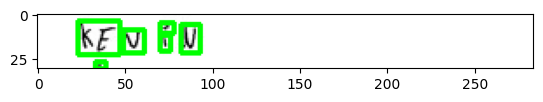

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Image 2: LCTYLILL1


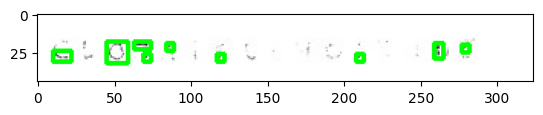

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Image 3: LENA


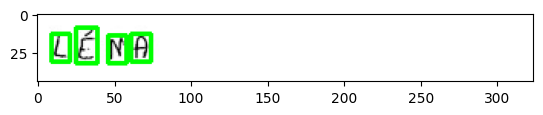

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Image 4: JJHIE9


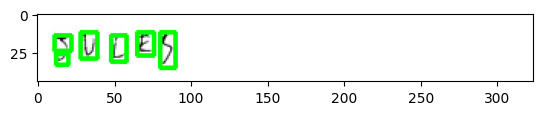

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Image 5: CHEBP11N


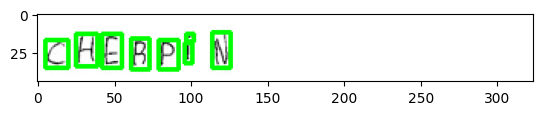

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Image 6: M3MAKT3N


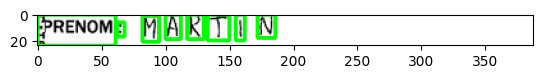

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Image 7: VALEWTJWE


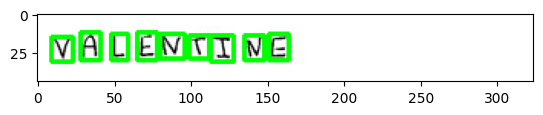

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Image 8: W3L7RAS


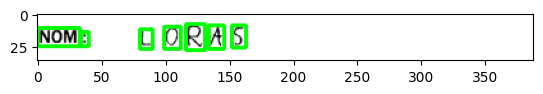

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Image 9: 9ZTH1BPULT


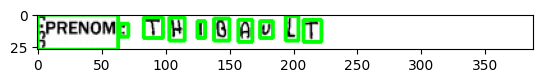

In [ ]:
# prompt: show results like above for 10 images

import matplotlib.pyplot as plt
import os
# Assuming 'landlord_handwriting_recognition_path' is defined and contains the image data.
# Replace with your actual path if necessary.

# Example usage (replace with your actual image paths)
for i in range(10):
    img_path = os.path.join(landlord_handwriting_recognition_path, f"test_v2/test/TEST_000{i}.jpg")
    try:
      letter, image = get_letters(img_path)
      if image is not None:  # Check if image loaded successfully
          word = get_word(letter)
          print(f"Image {i}: {word}")
          plt.imshow(image)
          plt.show()
      else:
          print(f"Could not process image: {img_path}")
    except Exception as e:  # Handle potential errors (file not found, etc.)
      print(f"Error processing image {i}: {e}")


In [ ]:
val_loss, val_accuracy = model.evaluate(val_X, val_Y, verbose=1)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8857 - loss: 0.3804
Validation Accuracy: 89.23%


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Add the .keras extension to the filepath
model.save('/content/drive/MyDrive/my_model.keras')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
